# Categorizing Partner Status: Modeling
This dataset was taken from the European Social Survey. The goal of this project will be to use gradient boosting and predict whether a person will be living with a partner given various social characteristics of that person.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sqlalchemy import create_engine
import time
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

## Load dataset
Load the cleaned dataset from the SQL database.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

Copy cleaned dataset to a new `DataFrame`, which will be transformed and used for modeling.

In [6]:
df_model = df.copy()

In [7]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 13 columns):
cntry      8594 non-null object
idno       8594 non-null float64
year       8594 non-null int64
tvtot      8594 non-null float64
ppltrst    8594 non-null float64
pplfair    8594 non-null float64
pplhlp     8594 non-null float64
happy      8594 non-null float64
sclmeet    8594 non-null float64
sclact     8594 non-null float64
gndr       8594 non-null float64
agea       8594 non-null float64
partner    8594 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 873.0+ KB


## Data Exploration
### Contious features
Exclude the features _idno_ and _cntry_ from the dataset, to only consider continous variables for the moment.

In [8]:
df_continuous = df_model.loc[:, ~df_model.columns.isin(['idno', 'cntry'])].copy()

### Outliers
Look for outliers.

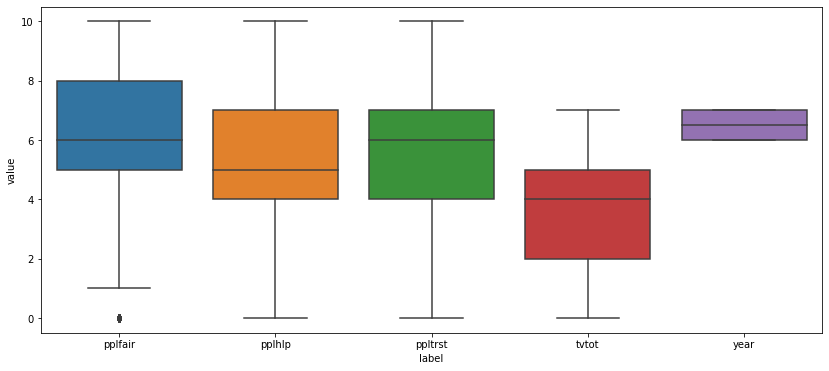

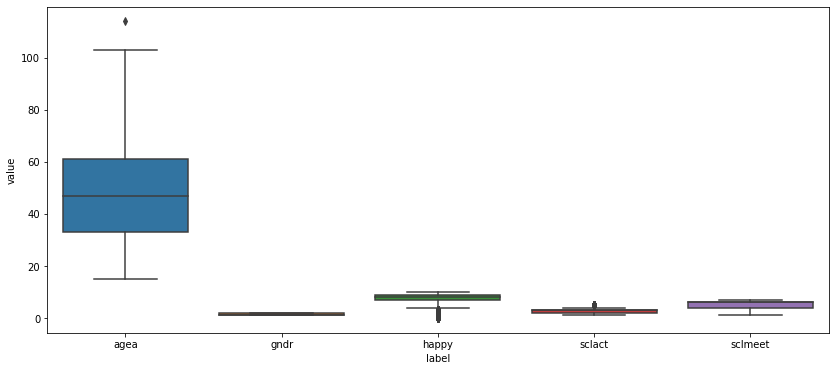

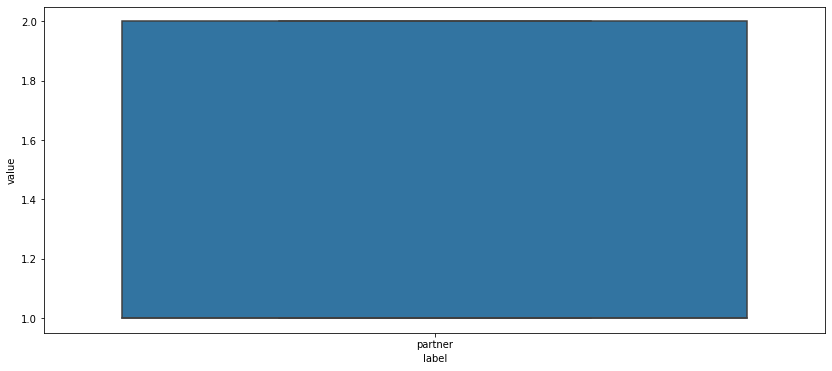

In [9]:
hp.look_for_outliers(df_continuous, df_continuous.columns.tolist(), max_boxes=5)

**Observations:** There are very few outliers in these variables.

### Variable distributions
Now, I will inspect the distribution shapes for each variable. If they are skewed, I will use Box-Cox to correct for the skewness.

In [10]:
df_continuous.columns

Index(['year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet',
       'sclact', 'gndr', 'agea', 'partner'],
      dtype='object')

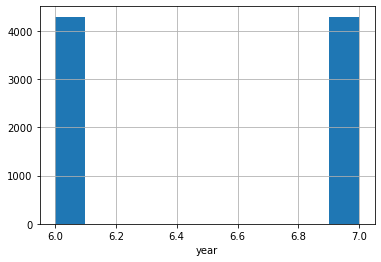

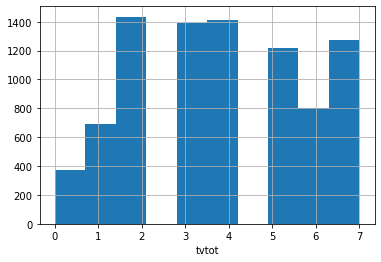

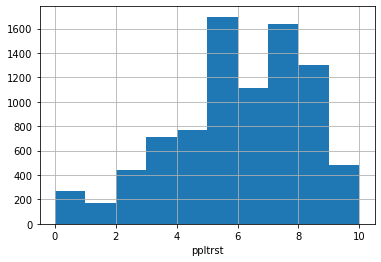

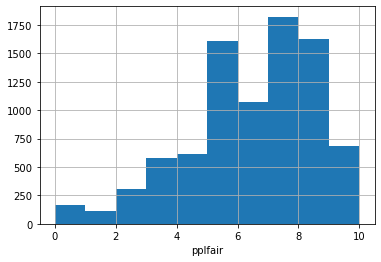

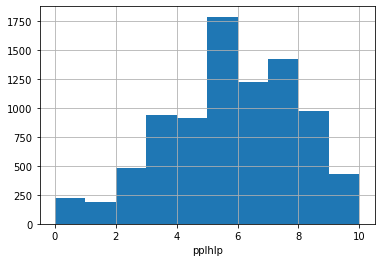

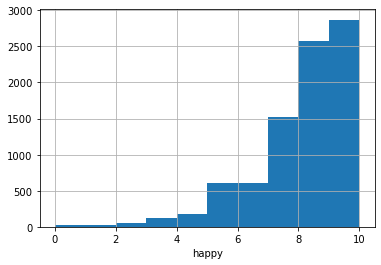

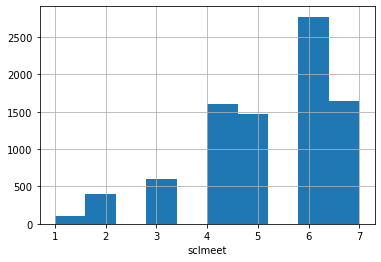

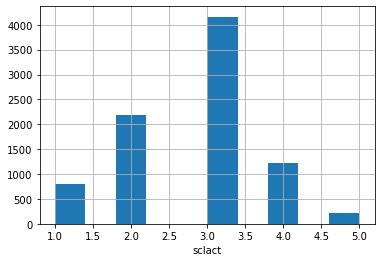

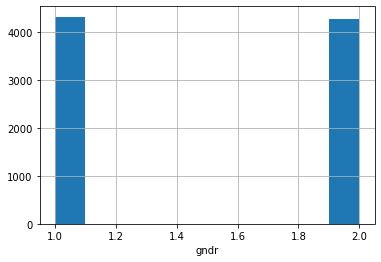

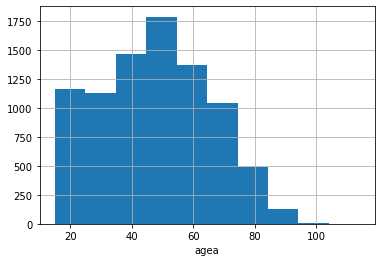

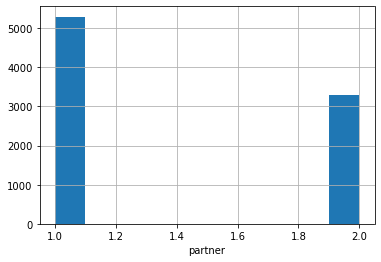

In [11]:
for column in df_continuous.columns:
    df_continuous[column].hist(bins=10)
    plt.xlabel(column)
    plt.show()

In [12]:
skewed_variables = ['ppltrst', 'pplfair', 'pplhlp', 'happy', 'sclmeet']
bc_variables = [f'{x}_bc' for x in skewed_variables]
other_variables = [x for x in df_continuous.columns if x not in skewed_variables]

In [13]:
df_continuous = hp.apply_boxcox_transform(df_continuous, skewed_variables).copy()

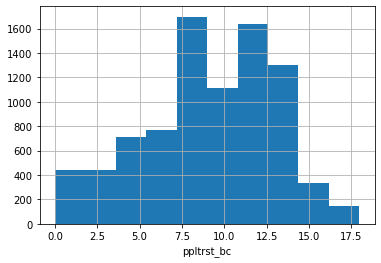

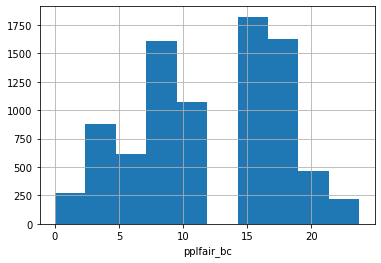

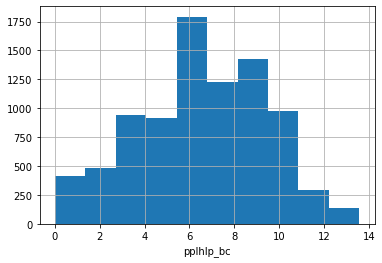

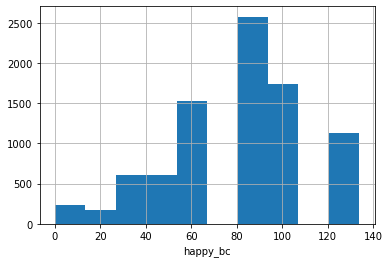

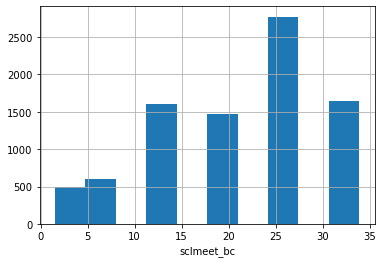

In [14]:
for column in bc_variables:
    df_continuous[column].hist(bins=10)
    plt.xlabel(column)
    plt.show()

**Observations:** Great, the distributions now look better.

Let's update the dataset by removing the skewed columns and just keeping the Box-Cox transformed columns.

In [15]:
df_continuous = df_continuous.loc[:, bc_variables+other_variables].copy()

### Correlations
Look for correlations between the continuous variables. Remove those variables with a high correlation.

In [16]:
df_continuous.corr()

,ppltrst_bc,pplfair_bc,pplhlp_bc,happy_bc,sclmeet_bc,year,tvtot,sclact,gndr,agea,partner
ppltrst_bc,1.000000,0.588867,0.457086,0.216998,0.116654,-0.002012,-0.142875,0.134634,-0.029846,-0.026435,-0.038917
pplfair_bc,0.588867,1.000000,0.474339,0.240899,0.091023,0.002865,-0.116379,0.127387,0.027060,0.022953,-0.034530
pplhlp_bc,0.457086,0.474339,1.000000,0.204345,0.070051,-0.031842,-0.068596,0.088543,0.040297,0.038749,-0.026594
happy_bc,0.216998,0.240899,0.204345,1.000000,0.174245,-0.023878,-0.109335,0.175521,-0.011617,-0.035542,-0.143612
sclmeet_bc,0.116654,0.091023,0.070051,0.174245,1.000000,-0.029998,-0.080095,0.265086,0.013128,-0.195017,0.171672
year,-0.002012,0.002865,-0.031842,-0.023878,-0.029998,1.000000,-0.030263,0.009559,-0.004189,-0.002855,0.016507
tvtot,-0.142875,-0.116379,-0.068596,-0.109335,-0.080095,-0.030263,1.000000,-0.097150,0.015045,0.257969,-0.025461
sclact,0.134634,0.127387,0.088543,0.175521,0.265086,0.009559,-0.097150,1.000000,-0.035703,-0.058503,0.006023
gndr,-0.029846,0.027060,0.040297,-0.011617,0.013128,-0.004189,0.015045,-0.035703,1.000000,0.024131,0.039063
agea,-0.026435,0.022953,0.038749,-0.035542,-0.195017,-0.002855,0.257969,-0.058503,0.024131,1.000000,-0.243389


In [17]:
correlated_columns = hp.find_correlated_features(df_continuous)

No columns found with r > 0.8.


**Observations:** No continuous variables have high correlations with eachother. Therefore, I will include all variables in the model.

### Categorical variable
Convert the categorical variable _cntry_ to dummies.

In [18]:
df_dummy = pd.get_dummies(df['cntry'])

### Combine variables
Combine the continuous variables and the categorical variable into a single dataset, which will be used for modeling.

In [19]:
df_model = pd.concat([df_continuous, df_dummy], axis=1)

## Model
### Train and test
Split dataset into train and test sets.

In [20]:
X = df_model.loc[:, ~df_model.columns.isin(['partner'])]
y = df_model['partner'] - 1

split_thresh = 0.9
split_index = int(len(df_model)*split_thresh)

X_train, y_train = X[:split_index], y[:split_index]

X_test, y_test = X[split_index:], y[split_index:]

### Setup model
Define the hypeparameters for the model.

In [21]:
hp.gbc_params = {'n_estimators': 500,
                 'max_depth': 2,
                 'loss': 'exponential'}

### Fit model, make predictions, and evaluate it

Train Metrics:
 * score: 76.778%
 * type 1 error: 5.185%
 * type 2 error: 18.037%
 * sensitivity: 79.788%
 * specificity: 75.739%
Test Metrics:
 * score: 74.651%
 * type 1 error: 6.512%
 * type 2 error: 18.837%
 * sensitivity: 74.194%
 * specificity: 74.806%


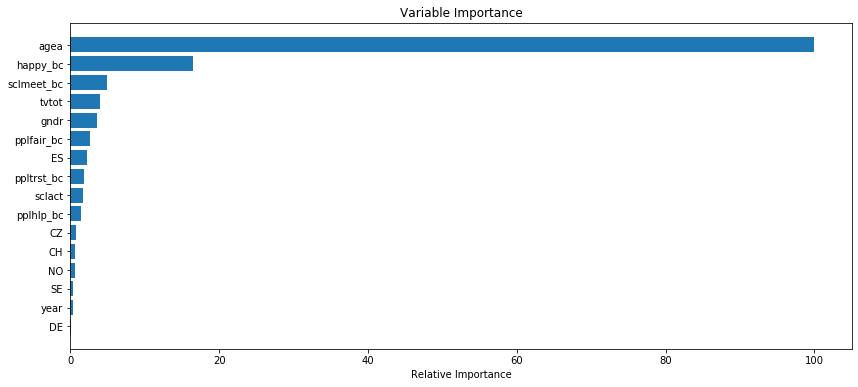

In [22]:
hp.run_gbc_classifier(X_train, X_test, y_train, y_test, print_results=True)